In [103]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [104]:
import os
import glob
import numpy as np
import os

In [105]:
class load_balanced_view_replace:
    
    def apply(self, func, *args):
        func(*args)
    
def func(a,b):
    print(a,b)
    
lv = load_balanced_view_replace()
lv.apply(func, 1, 2)

1 2


In [106]:
try:
    # have IPython.parallel?
    
    from IPython.parallel import Client
    c = Client()
    lv = c.load_balanced_view()   # this object represents the engines (workers)
    print("Using IPython.parallel.")
except:
    class task:
        def __init__(self, result):
            self.result = result
            
        def get(self):
            return self.result
        
    # else, execute commands in sequence
    class load_balanced_view_replace:
    
        def apply(self, func, *args):
            return task( func(*args) )
    
    lv = load_balanced_view_replace()

Using IPython.parallel.


In [107]:
field='COSMOSC'

In [108]:
def filter_cube(f, DRYRUN=True):
    import os
    h,t = os.path.split(f)
    cmd="python filter_cube.py --infile {} --outfile {}".format(f,os.path.join(h,"sf2" + t) )
    if DRYRUN:
        print(cmd)
        return -1, cmd
    else:
        return os.system( cmd ), cmd

In [9]:
# filter data cubes
ff = np.sort( glob.glob("data/outcube_{}_???.fits.gz".format(field)) )

tasks = []
for f in ff:
    tasks.append(lv.apply(filter_cube, f))
result = [task.get() for task in tasks]  # blocks until all results are back

In [225]:
#build noise model
def noise_model(f, DRYRUN=True):
    import os
    h,t = os.path.split(f)
    cmd="python noise_model2.py --infile {} --outfile {}".format(f,os.path.join(h,"nc" + t) )
    if DRYRUN:
        print(cmd)
        return -1, cmd
    else:
        return os.system( cmd ), cmd

tasks = []
for f in ff:
    tasks.append(lv.apply(noise_model, f))
result = [task.get() for task in tasks]  # blocks until all results are back

for r in result:
    print(r)

(-1, 'python noise_model2.py --infile data/sf2outcube_COSMOSC_021.fits.gz --outfile data/ncsf2outcube_COSMOSC_021.fits.gz')
(-1, 'python noise_model2.py --infile data/sf2outcube_COSMOSC_022.fits.gz --outfile data/ncsf2outcube_COSMOSC_022.fits.gz')
(-1, 'python noise_model2.py --infile data/sf2outcube_COSMOSC_023.fits.gz --outfile data/ncsf2outcube_COSMOSC_023.fits.gz')
(-1, 'python noise_model2.py --infile data/sf2outcube_COSMOSC_024.fits.gz --outfile data/ncsf2outcube_COSMOSC_024.fits.gz')
(-1, 'python noise_model2.py --infile data/sf2outcube_COSMOSC_025.fits.gz --outfile data/ncsf2outcube_COSMOSC_025.fits.gz')
(-1, 'python noise_model2.py --infile data/sf2outcube_COSMOSC_026.fits.gz --outfile data/ncsf2outcube_COSMOSC_026.fits.gz')
(-1, 'python noise_model2.py --infile data/sf2outcube_COSMOSC_027.fits.gz --outfile data/ncsf2outcube_COSMOSC_027.fits.gz')
(-1, 'python noise_model2.py --infile data/sf2outcube_COSMOSC_032.fits.gz --outfile data/ncsf2outcube_COSMOSC_032.fits.gz')
(-1, 'py

In [11]:
# filter noise cubes
ff = np.sort( glob.glob("data/ncoutcube_{}_???.fits.gz".format(field)) )

tasks = []
for f in ff:
    tasks.append(lv.apply(filter_cube, f))
result = [task.get() for task in tasks]  # blocks until all results are back

# don't need the unsmoothed noise cubes anymore
cmd="rm data/ncoutcube_{}_???.fits.gz".format(field)

In [12]:
detect_limits = {}

detect_limits['COSMOSA'] = { 'detect_threshold':0.35, 'grow_threshold':0.21}
detect_limits['COSMOSB'] = { 'detect_threshold':0.64, 'grow_threshold':0.39}
detect_limits['COSMOSC'] = { 'detect_threshold':0.64, 'grow_threshold':0.39}
detect_limits['COSMOSD'] = { 'detect_threshold':0.64, 'grow_threshold':0.39}

In [13]:
if False:
    # run detect and segmentation
    def cloud_finder2(f, field, detect_limits):
        import os
        h,t = os.path.split(f)
        dt, gt = detect_limits[field]['detect_threshold'], detect_limits[field]['grow_threshold']
        cmd = "python cloud_finder2.py -i {} --detect_threshold {} --grow_threshold {} -b {} -o {}".format(f,dt,gt,f.replace('.fits.gz','.badregs'),f.replace('sf2outcube','map'))
        return cmd
        #return os.system( cmd )

    ff = np.sort( glob.glob("data/sf2outcube_{}_???.fits.gz".format(field)) )

    tasks = []
    for f in ff:
        tasks.append(lv.apply(cloud_finder2, f, field, detect_limits))
    result = [task.get() for task in tasks]  # blocks until all results are back

    for r in result:
        print(r)

In [226]:
# run detect and segmentation
def build_detect_noise_model(f, DRYRUN=True):
    import os
    detect_noise_model = f.replace(".fits.gz",".detect_noise_model")
    cmd = "python detection_noise_model.py -i {} -o {}".format(f,detect_noise_model)
    if DRYRUN:
        print(cmd)
        return -1, cmd
    else:
        return os.system( cmd ), cmd

ff = np.sort( glob.glob("data/sf2outcube_{}_???.fits.gz".format(field)) )

tasks = []
for f in ff:
    tasks.append(lv.apply(build_detect_noise_model, f))
result = [task.get() for task in tasks]  # blocks until all results are back

for r in result:
   print(r)

(-1, 'python detection_noise_model.py -i data/sf2outcube_COSMOSC_021.fits.gz -o data/sf2outcube_COSMOSC_021.detect_noise_model')
(-1, 'python detection_noise_model.py -i data/sf2outcube_COSMOSC_022.fits.gz -o data/sf2outcube_COSMOSC_022.detect_noise_model')
(-1, 'python detection_noise_model.py -i data/sf2outcube_COSMOSC_023.fits.gz -o data/sf2outcube_COSMOSC_023.detect_noise_model')
(-1, 'python detection_noise_model.py -i data/sf2outcube_COSMOSC_024.fits.gz -o data/sf2outcube_COSMOSC_024.detect_noise_model')
(-1, 'python detection_noise_model.py -i data/sf2outcube_COSMOSC_025.fits.gz -o data/sf2outcube_COSMOSC_025.detect_noise_model')
(-1, 'python detection_noise_model.py -i data/sf2outcube_COSMOSC_026.fits.gz -o data/sf2outcube_COSMOSC_026.detect_noise_model')
(-1, 'python detection_noise_model.py -i data/sf2outcube_COSMOSC_027.fits.gz -o data/sf2outcube_COSMOSC_027.detect_noise_model')
(-1, 'python detection_noise_model.py -i data/sf2outcube_COSMOSC_032.fits.gz -o data/sf2outcube_C

In [228]:
sigma_detect_threshold = 5.
sigma_grow_threshold = 3.

# run detect and segmentation
def cloud_finder3(f, field, sigma_detect_threshold, sigma_grow_threshold, DRYRUN=True):
    import os
    h,t = os.path.split(f)
    detect_noise_model = f.replace(".fits.gz",".detect_noise_model")
    
    cmd = "python cloud_finder3.py -i {} --sigma_detect_threshold {} --sigma_grow_threshold {} -b {} -o {} -n {}".\
        format(f,sigma_detect_threshold, sigma_grow_threshold,f.replace('.fits.gz','.badregs'),f.replace('sf2outcube','map'),detect_noise_model)
    if DRYRUN:
        print(cmd)
        return -1, cmd
    else:
        return os.system( cmd ), cmd
    
    return os.system( cmd )

ff = np.sort( glob.glob("data/sf2outcube_{}_???.fits.gz".format(field)) )

tasks = []
for f in ff:
    tasks.append(lv.apply(cloud_finder3, f, field, sigma_detect_threshold, sigma_grow_threshold))
result = [task.get() for task in tasks]  # blocks until all results are back

for r in result:
    print(r)

(-1, 'python cloud_finder3.py -i data/sf2outcube_COSMOSC_021.fits.gz --sigma_detect_threshold 5.0 --sigma_grow_threshold 3.0 -b data/sf2outcube_COSMOSC_021.badregs -o data/map_COSMOSC_021.fits.gz -n data/sf2outcube_COSMOSC_021.detect_noise_model')
(-1, 'python cloud_finder3.py -i data/sf2outcube_COSMOSC_022.fits.gz --sigma_detect_threshold 5.0 --sigma_grow_threshold 3.0 -b data/sf2outcube_COSMOSC_022.badregs -o data/map_COSMOSC_022.fits.gz -n data/sf2outcube_COSMOSC_022.detect_noise_model')
(-1, 'python cloud_finder3.py -i data/sf2outcube_COSMOSC_023.fits.gz --sigma_detect_threshold 5.0 --sigma_grow_threshold 3.0 -b data/sf2outcube_COSMOSC_023.badregs -o data/map_COSMOSC_023.fits.gz -n data/sf2outcube_COSMOSC_023.detect_noise_model')
(-1, 'python cloud_finder3.py -i data/sf2outcube_COSMOSC_024.fits.gz --sigma_detect_threshold 5.0 --sigma_grow_threshold 3.0 -b data/sf2outcube_COSMOSC_024.badregs -o data/map_COSMOSC_024.fits.gz -n data/sf2outcube_COSMOSC_024.detect_noise_model')
(-1, 'py

In [213]:
# add segmants for manually flagged 
def apply_manual_catalog(f, field, sigma_grow_threshold, DRYRUN=False):
    import os
    h,t = os.path.split(f)
    ifu = t.replace('.fits.gz','').split("_")[-1]
    fncatalog = "data/{}_{}.txt".format(field, ifu)
    detect_noise_model = f.replace(".fits.gz",".detect_noise_model")
    
    cmd = "python apply_manual_catalog.py -i {} -s {} -m {} -n {} -o {} -c {}".\
        format(f, sigma_grow_threshold, f.replace('sf2outcube','map'), \
               detect_noise_model, f.replace('sf2outcube','mmap'), fncatalog)
    if DRYRUN:
        print(cmd)
        return cmd
    else:
        return os.system( cmd ), cmd
    
    return os.system( cmd )

ff = np.sort( glob.glob("data/sf2outcube_{}_???.fits.gz".format(field)) )

sigma_grow_threshold = 2.0

tasks = []
for f in ff:
    tasks.append(lv.apply(apply_manual_catalog, f, field, sigma_grow_threshold))
result = [task.get() for task in tasks]  # blocks until all results are back

for r in result:
    print(r)

#python apply_manual_catalog.py -i data/sf2outcube_COSMOSC_021.fits.gz --sigma_grow_threshold 1.7  
#-m data/map_COSMOSC_021.fits.gz -n data/sf2outcube_COSMOSC_021.detect_noise_model -o data/mmap_COSMOSC_021.fits.gz -c data/COSMOSC_021.txt

(0, 'python apply_manual_catalog.py -i data/sf2outcube_COSMOSC_021.fits.gz -s 2.0 -m data/map_COSMOSC_021.fits.gz -n data/sf2outcube_COSMOSC_021.detect_noise_model -o data/mmap_COSMOSC_021.fits.gz -c data/COSMOSC_021.txt')
(0, 'python apply_manual_catalog.py -i data/sf2outcube_COSMOSC_022.fits.gz -s 2.0 -m data/map_COSMOSC_022.fits.gz -n data/sf2outcube_COSMOSC_022.detect_noise_model -o data/mmap_COSMOSC_022.fits.gz -c data/COSMOSC_022.txt')
(0, 'python apply_manual_catalog.py -i data/sf2outcube_COSMOSC_023.fits.gz -s 2.0 -m data/map_COSMOSC_023.fits.gz -n data/sf2outcube_COSMOSC_023.detect_noise_model -o data/mmap_COSMOSC_023.fits.gz -c data/COSMOSC_023.txt')
(0, 'python apply_manual_catalog.py -i data/sf2outcube_COSMOSC_024.fits.gz -s 2.0 -m data/map_COSMOSC_024.fits.gz -n data/sf2outcube_COSMOSC_024.detect_noise_model -o data/mmap_COSMOSC_024.fits.gz -c data/COSMOSC_024.txt')
(0, 'python apply_manual_catalog.py -i data/sf2outcube_COSMOSC_025.fits.gz -s 2.0 -m data/map_COSMOSC_025.fi

In [223]:
#sf2outcube_COSMOSA_044.fits.gz
#map_COSMOSB_042.fits.gz


# build catalog
def build_catalog(f, field, DRYRUN=False):
    import os
    ifu = f[-11:-8]
    
    cmd = "python build_catalog.py -i {f} -m data/mmap_{field}_{ifu}.fits.gz -c specphot/mean_cal_{field}.txt -o data/msf2outcube_{field}_{ifu}.cat"\
        .format(f=f,field=field,ifu=ifu)
    
    if DRYRUN:
        return -1, cmd
    
    return os.system( cmd ), cmd

ff = np.sort( glob.glob("data/sf2outcube_{}_???.fits.gz".format(field)) )

tasks = []
for f in ff:
    tasks.append(lv.apply(build_catalog, f, field))
result = [task.get() for task in tasks]  # blocks until all results are back

for r in result:
    print(r)

(0, 'python build_catalog.py -i data/sf2outcube_COSMOSC_021.fits.gz -m data/mmap_COSMOSC_021.fits.gz -c specphot/mean_cal_COSMOSC.txt -o data/msf2outcube_COSMOSC_021.cat')
(0, 'python build_catalog.py -i data/sf2outcube_COSMOSC_022.fits.gz -m data/mmap_COSMOSC_022.fits.gz -c specphot/mean_cal_COSMOSC.txt -o data/msf2outcube_COSMOSC_022.cat')
(0, 'python build_catalog.py -i data/sf2outcube_COSMOSC_023.fits.gz -m data/mmap_COSMOSC_023.fits.gz -c specphot/mean_cal_COSMOSC.txt -o data/msf2outcube_COSMOSC_023.cat')
(0, 'python build_catalog.py -i data/sf2outcube_COSMOSC_024.fits.gz -m data/mmap_COSMOSC_024.fits.gz -c specphot/mean_cal_COSMOSC.txt -o data/msf2outcube_COSMOSC_024.cat')
(0, 'python build_catalog.py -i data/sf2outcube_COSMOSC_025.fits.gz -m data/mmap_COSMOSC_025.fits.gz -c specphot/mean_cal_COSMOSC.txt -o data/msf2outcube_COSMOSC_025.cat')
(0, 'python build_catalog.py -i data/sf2outcube_COSMOSC_026.fits.gz -m data/mmap_COSMOSC_026.fits.gz -c specphot/mean_cal_COSMOSC.txt -o dat

In [224]:
# add segmants for manually flagged 
def add_manual_info(f, field, DRYRUN=True):
    import os
    h,t = os.path.split(f)
    ifu = t.replace('.fits.gz','').split("_")[-1]
    
    fncatalog = "data/{}_{}.txt".format(field, ifu)

    #python src/add_manual_info.py -m data/mmap_COSMOSC_021.fits.gz 
    # -c data/COSMOSC_021.txt -a data/msf2outcube_COSMOSC_021.cat
    
    cmd = "python src/add_manual_info.py -m {} -c {} -a {}".\
        format(f.replace('sf2outcube','mmap'), fncatalog, f.replace('.fits.gz','.cat').replace("sf2outcube","msf2outcube"))
    if DRYRUN:
        print(cmd)
        return cmd
    else:
        return os.system( cmd ), cmd
    
    return os.system( cmd )

ff = np.sort( glob.glob("data/sf2outcube_{}_???.fits.gz".format(field)) )

tasks = []
for f in ff:
    tasks.append(lv.apply(add_manual_info, f, field))
result = [task.get() for task in tasks]  # blocks until all results are back

for r in result:
    print(r)

python src/add_manual_info.py -m data/mmap_COSMOSC_021.fits.gz -c data/COSMOSC_021.txt -a data/msf2outcube_COSMOSC_021.cat
python src/add_manual_info.py -m data/mmap_COSMOSC_022.fits.gz -c data/COSMOSC_022.txt -a data/msf2outcube_COSMOSC_022.cat
python src/add_manual_info.py -m data/mmap_COSMOSC_023.fits.gz -c data/COSMOSC_023.txt -a data/msf2outcube_COSMOSC_023.cat
python src/add_manual_info.py -m data/mmap_COSMOSC_024.fits.gz -c data/COSMOSC_024.txt -a data/msf2outcube_COSMOSC_024.cat
python src/add_manual_info.py -m data/mmap_COSMOSC_025.fits.gz -c data/COSMOSC_025.txt -a data/msf2outcube_COSMOSC_025.cat
python src/add_manual_info.py -m data/mmap_COSMOSC_026.fits.gz -c data/COSMOSC_026.txt -a data/msf2outcube_COSMOSC_026.cat
python src/add_manual_info.py -m data/mmap_COSMOSC_027.fits.gz -c data/COSMOSC_027.txt -a data/msf2outcube_COSMOSC_027.cat
python src/add_manual_info.py -m data/mmap_COSMOSC_032.fits.gz -c data/COSMOSC_032.txt -a data/msf2outcube_COSMOSC_032.cat
python src/add_m

In [ ]:

#combine (vstack) all tables from this field
from astropy.table import vstack, Column
from astropy.io import ascii

ff = glob.glob("data/msf2outcube_{field}_???.cat".format(field=field))
#print(ff)
tt = []
for f in ff:
    ifu = f[-7:-4]
    print(ifu)
    t = ascii.read(f, format="ecsv")
    t.add_column(Column([ifu]*len(t),name='ifu'),0)
    tt.append(t)
 
tall = vstack(tt)
tall.write("data/msf2outcube_{field}_allifu.cat".format(field=field),format="ascii.ecsv")   


In [236]:
tall = vstack(tt)
tall.write("data/msf2outcube_{field}_allifu.cat".format(field=field),format="ascii.ecsv")   


In [182]:
halos = (tall["class"] == "halo" ).data

In [232]:
ii = tall["id"] > 10000
ii *= halos
np.sum(ii)

ValueError: operands could not be broadcast together with shapes (2872,) (2814,) (2872,) 

In [233]:
tall[ii]

ifu,id,N,counts,flux,ra_com,dec_com,ddec,dra,x_com,y_com,z_com,dx,dy,dz,sqrt(ev1),sqrt(ev2),size2d,x_ext,y_ext,z_ext,wl_com,dwl,xmin,xmax,ymin,ymax,zmin,zmax,class,manualx,manualy,manualz
,,px,counts,erg / (cm2 s),RA[J2000],Dec[J2000],arcsec,arcsec,px,px,px,px,px,px,px,px,px,px,px,px,A,A,px,px,px,px,px,px,,,,
str3,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,int64,int64,int64,int64,int64,int64,str8,float64,float64,float64
097,10001,1238,3.9769e+02,1.6063e-16,150.080332,2.293728,1.8,1.4,63.92,60.38,61.88,3.54,2.86,8.50,3.57,2.83,4.56,16,14,27,3615.63,53.62,54,70,54,68,48,75,halo,65.0,58.0,51.0
097,10002,6465,2.4829e+03,7.0942e-16,150.080023,2.289977,6.3,3.9,66.14,33.37,147.05,12.67,7.77,20.29,13.09,7.03,14.86,44,34,78,3784.77,154.90,46,90,19,53,99,177,fil,56.0,43.0,160.0
097,10003,1322,5.4595e+02,1.3449e-16,150.080196,2.291281,2.1,3.8,64.90,42.76,196.61,4.14,7.61,7.76,3.85,7.76,8.67,20,30,29,3883.19,57.59,55,75,34,64,182,211,EL,71.0,40.0,208.0
097,10004,751,3.2000e+02,7.5351e-17,150.074143,2.295736,1.1,2.1,108.44,74.83,207.13,2.28,4.11,3.08,2.27,4.11,4.70,11,19,13,3904.08,25.82,103,114,66,85,201,214,EL,108.0,76.0,208.0
097,10005,633,2.6699e+02,5.5217e-17,150.078075,2.294435,1.1,1.8,80.16,65.47,238.38,2.19,3.68,3.08,2.17,3.69,4.28,10,17,13,3966.13,25.82,75,85,56,73,233,246,EL,78.0,67.0,238.0
097,10006,4846,1.9712e+03,3.5565e-16,150.077647,2.293448,4.5,3.1,83.23,58.37,277.14,9.05,6.17,18.24,9.09,6.13,10.96,48,35,68,4043.10,135.04,59,107,38,73,247,315,EL,81.0,65.0,257.0
097,10007,344,1.4996e+02,2.8900e-17,150.079812,2.293909,0.8,1.5,67.66,61.68,256.54,1.68,3.04,2.08,1.42,3.17,3.47,8,13,9,4002.21,17.87,64,72,56,69,252,261,EL,69.0,60.0,257.0
097,10008,356,1.6984e+02,3.0304e-17,150.079113,2.290643,1.1,0.9,72.68,38.17,275.91,2.27,1.87,2.25,2.64,1.30,2.94,11,8,12,4040.68,23.83,67,78,34,42,268,280,EL,73.0,37.0,277.0


In [ ]:
from matplotlib import pyplot as plt
% matplotlib inline

plt.figure(figsize=[7,7])

plt.plot( tall["ra_com"][ii], tall["dec_com"][ii], '.', alpha=.2)
plt.xlabel("RA[Deg]")
plt.ylabel("Dec[Deg]")
plt.ax
invert_yaxis


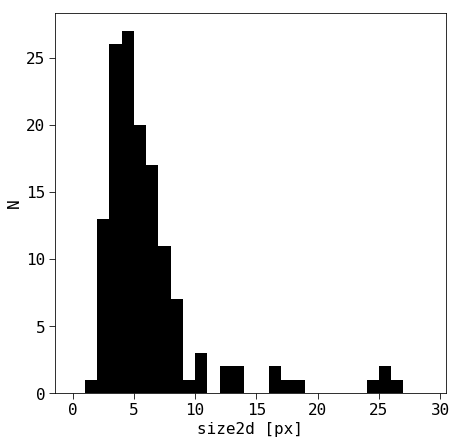

In [185]:
plt.figure(figsize=[7,7])
__ = plt.hist( tall['size2d'][ii], bins=np.arange(0.,30.,1.))
plt.xlabel("size2d [px]")
plt.ylabel("N")


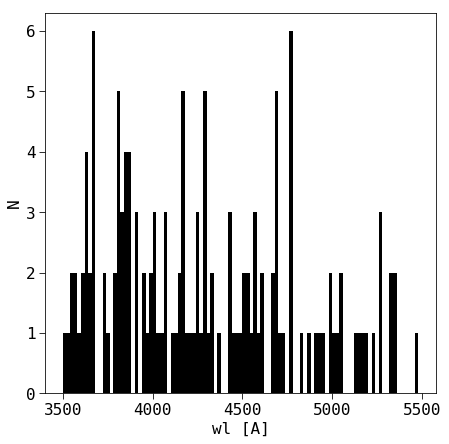

In [186]:
plt.figure(figsize=[7,7])
__ = plt.hist( tall['wl_com'][ii], bins=np.arange(3500,5500,20.))
plt.xlabel("wl [A]")
plt.ylabel("N")


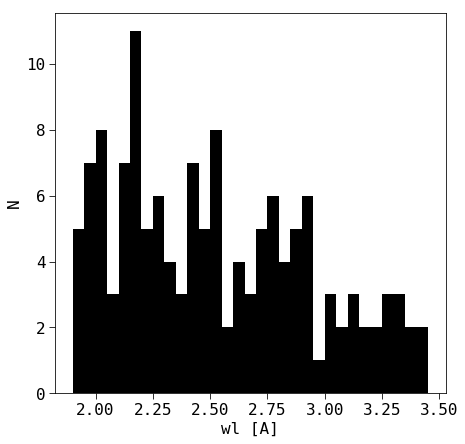

In [187]:
plt.figure(figsize=[7,7])
__ = plt.hist( tall['wl_com'][ii]/1216.-1., bins=np.arange(1.9,3.5,.05))
plt.xlabel("wl [A]")
plt.ylabel("N")


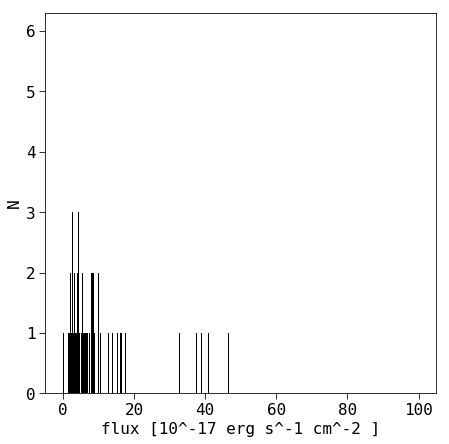

In [188]:
plt.figure(figsize=[7,7])
__ = plt.hist( tall['flux'][ii]*1e17, bins=np.arange(0,100,.1))
plt.xlabel("flux [10^-17 erg s^-1 cm^-2 ]")
plt.ylabel("N")


/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


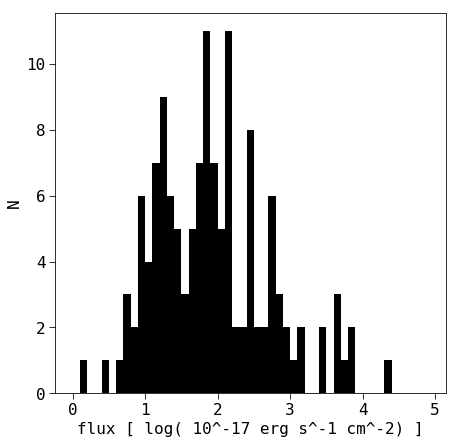

In [189]:
plt.figure(figsize=[7,7])
__ = plt.hist( np.log( tall['flux'][ii]*1e17 ) , bins=np.arange(0,5,.1))
plt.xlabel("flux [ log( 10^-17 erg s^-1 cm^-2) ]")
plt.ylabel("N")




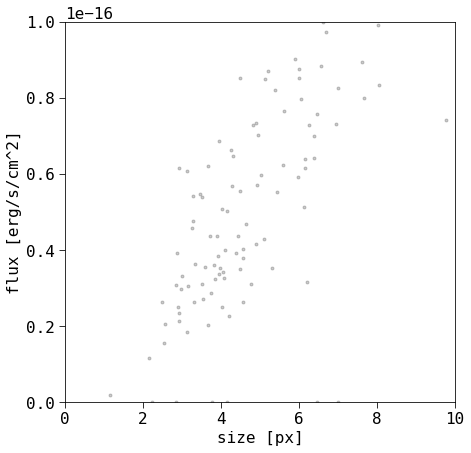

In [191]:
from matplotlib import pyplot as plt
% matplotlib inline

plt.figure(figsize=[7,7])
plt.plot( tall["size2d"][ii], tall["flux"][ii], '.', alpha=.2)
plt.ylim(0.,1e-16)
plt.xlim(0.,10.)
plt.xlabel("size [px]")
plt.ylabel("flux [erg/s/cm^2]")


(0.0, 1000.0)

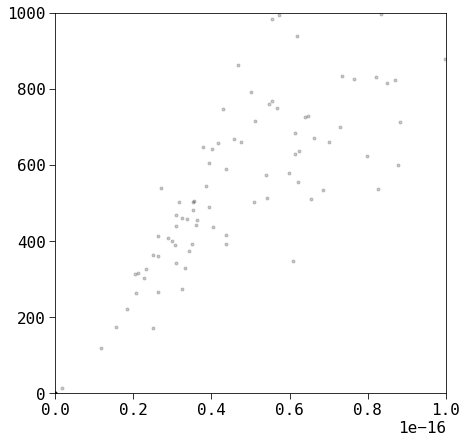

In [192]:
from matplotlib import pyplot as plt
% matplotlib inline

plt.figure(figsize=[7,7])
plt.plot( tall["flux"][ii], tall["N"][ii], '.', alpha=.2)
plt.xlim(0.,1e-16)
plt.ylim(0.,1000.)
#plt.xlabel("RA[Deg]")
#plt.ylabel("Dec[Deg]")

(0.0, 150.0)

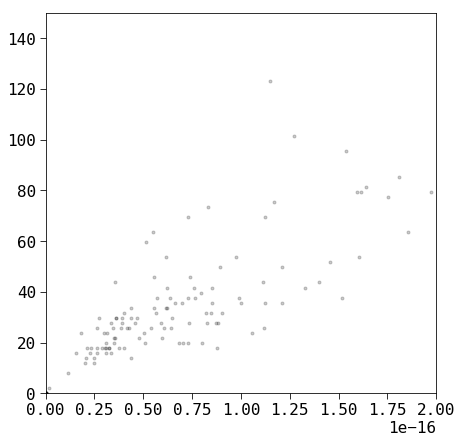

In [193]:
plt.figure(figsize=[7,7])
plt.plot( tall["flux"][ii], tall["dwl"][ii], '.', alpha=.2)
plt.xlim(0.,2e-16)
plt.ylim(0.,150.)


In [158]:
from astropy.table import Table
t = Table( [Column(['']*100,dtype='S100', name='foo')] )

In [160]:
t['foo'][0] = 'asdklfnalskfn'

In [161]:
t

foo
bytes100
asdklfnalskfn
""
""
""
""
""
""
""
""
